In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('laptops.csv')
df.head()

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [4]:
df.columns

Index(['laptop', 'status', 'brand', 'model', 'cpu', 'ram', 'storage',
       'storage_type', 'gpu', 'screen', 'touch', 'final_price'],
      dtype='object')

In [5]:
base_column = ['ram', 'storage', 'screen', 'final_price']
df1 = df[base_column]

In [6]:
df1.head()

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01


In [7]:
df1.isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

In [10]:
df1.ram.median()

np.float64(16.0)

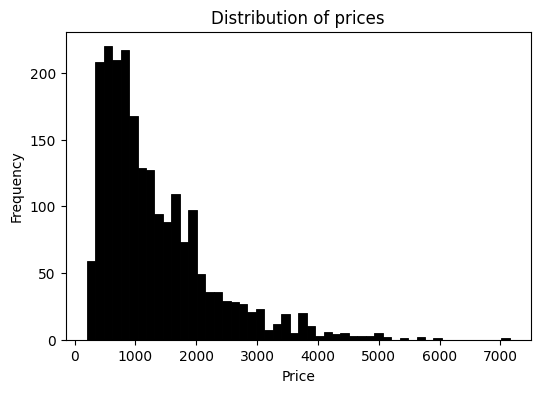

In [11]:
plt.figure(figsize=(6, 4))

sns.histplot(df.final_price, bins=50, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

In [12]:
np.random.seed(42)
n = len(df)
n_test = int(n * 0.2)
n_val = int(n * 0.2)
n_train = n - (n_test + n_val)

idx = np.arange(n)
np.random.shuffle(idx)

df_sh = df1.iloc[idx]
df_train = df_sh.iloc[:n_train].copy()
df_val = df_sh.iloc[n_train:n_train + n_val].copy()
df_test = df_sh.iloc[n_train + n_val:].copy()

y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values

del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

In [13]:
def train(X, y):
    X = np.column_stack([np.ones(X.shape[0]), X])
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

In [14]:
def prepare(df, fill_na = 0):
    dfc = df.fillna(fill_na)
    return dfc.values

In [15]:
X_train = prepare(df_train)

In [16]:
w0, w = train(X_train, y_train)

In [17]:
w0, w

(np.float64(676.8954853003995),
 array([ 43.70681555,   0.86506867, -36.10399833]))

In [18]:
y_train_pred = w0 + X_train.dot(w)

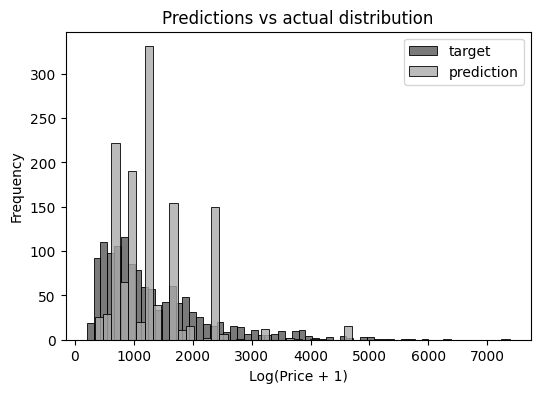

In [19]:
plt.figure(figsize=(6, 4))

sns.histplot(y_train, label='target', color='#222222', alpha=0.6, bins=50)
sns.histplot(y_train_pred, label='prediction', color='#aaaaaa', alpha=0.8, bins=50)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution')

plt.show()

In [20]:
def mrse(y_pred, y_target):
    return np.sqrt(((y_pred - y_target)**2).mean())

In [21]:
round(mrse(y_train_pred, y_train), 2)

np.float64(602.39)

In [22]:
X_val = prepare(df_val)

In [23]:
y_val_pred = w0 + X_val.dot(w)

In [24]:
round(mrse(y_val, y_val_pred), 2)

np.float64(597.36)

In [25]:
X_train1 = prepare(df_train, df_train.mean())

In [26]:
w01, w1 = train(X_train1, y_train)

In [27]:
w01, w1

(np.float64(808.9159907334033),
 array([ 43.90774584,   0.87135236, -45.18273312]))

In [28]:
y_train_pred1 = w01 + X_train1.dot(w1)

In [29]:
round(mrse(y_train, y_train_pred1), 2)

np.float64(602.18)

In [30]:
X_val1 = prepare(df_val, df_train.mean())

In [31]:
y_val_pred1 = w01 + X_val1.dot(w1)

In [34]:
round(mrse(y_val, y_val_pred1), 2)

np.float64(600.27)

In [35]:
def train_reg(X, y, r):
    X = np.column_stack([np.ones(X.shape[0]), X])
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

In [37]:
for r in [0, 0.01, 1, 10, 100]:
    w0r, wr = train_reg(X_train, y_train, r)
    y_val_pred = w0r + X_val.dot(wr)
    print(r, '\t', round(mrse(y_val, y_val_pred), 2))

0 	 597.36
0.01 	 597.36
1 	 597.21
10 	 597.06
100 	 597.9


In [38]:
mrses = []
for s in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    np.random.seed(s)
    n = len(df)
    n_test = int(n * 0.2)
    n_val = int(n * 0.2)
    n_train = n - (n_test + n_val)
    
    idx = np.arange(n)
    np.random.shuffle(idx)
    
    df_sh = df1.iloc[idx]
    df_train = df_sh.iloc[:n_train].copy()
    df_val = df_sh.iloc[n_train:n_train + n_val].copy()
    df_test = df_sh.iloc[n_train + n_val:].copy()
    
    y_train = df_train.final_price.values
    y_val = df_val.final_price.values
    y_test = df_test.final_price.values
    
    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']

    X_train = prepare(df_train)
    X_val = prepare(df_val)
    w0, w = train(X_train, y_train)
    y_val_pred = w0 + X_val.dot(w)
    mrses.append(mrse(y_val_pred, y_val))

mrses

[np.float64(565.4520868771027),
 np.float64(636.7985423056726),
 np.float64(588.9558697907962),
 np.float64(597.8148920012521),
 np.float64(571.962791511102),
 np.float64(573.2383256618949),
 np.float64(647.3438328407208),
 np.float64(550.4398184485952),
 np.float64(587.333503616991),
 np.float64(576.1017929433108)]

In [39]:
round(np.std(mrses), 3)

np.float64(29.176)

In [43]:
np.random.seed(9)
n = len(df)
n_test = int(n * 0.2)
n_val = int(n * 0.2)
n_train = n - (n_test + n_val)
    
idx = np.arange(n)
np.random.shuffle(idx)
    
df_sh = df1.iloc[idx]
df_train = df_sh.iloc[:n_train].copy()
df_val = df_sh.iloc[n_train:n_train + n_val].copy()
df_test = df_sh.iloc[n_train + n_val:].copy()
    
y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values
    
del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

df_train_u = pd.concat([df_train, df_val])
y_train_u = np.concat([y_train, y_val])

X_train_u = prepare(df_train_u)
X_test = prepare(df_test)
w0, w = train_reg(X_train_u, y_train_u, 0.001)
y_test_pred = w0 + X_test.dot(w)
round(mrse(y_test_pred, y_test), 2)

np.float64(608.61)